### 1. Data preprocessing

In [1]:
%matplotlib inline
plt.style.use('bmh')
# %matplotlib widget

# 1) read data
df = pd.read_csv('data/input.csv')
# print(df.shape)

# 2) preprocessing
df.drop_duplicates(subset = ['CODI EOI','DATA','CONTAMINANT'], inplace = True)
# print(df.shape)
dict_repl = {
    "Ribera d¿Ebre": "Ribera d'Ebre"
}
df['NOM COMARCA'] = df['NOM COMARCA'].map(lambda x: dict_repl[x] if x in dict_repl else x)
df['DATA'] = pd.to_datetime(df['DATA'], dayfirst = True)

df['year'] = df['DATA'].dt.year
df['month'] = df['DATA'].dt.month
df['weekday'] = df['DATA'].dt.dayofweek
df['year_month'] = pd.to_datetime(df['DATA'].astype(str).str[:7] + '-01')

# 3) features lists
feats10 = ['CODI EOI', 'CODI INE', 'CODI COMARCA', 'NOM ESTACIO', 'MUNICIPI', 'NOM COMARCA', 'ALTITUD']
feats11 = ['TIPUS ESTACIO', 'AREA URBANA', 'LATITUD','LONGITUD', 'GEOREFERENCIA']
feats2  = ['MAGNITUD', 'CONTAMINANT', 'UNITATS']

feat_dt     = ['DATA']
feats_vals  = ['01h','02h','03h','04h','05h','06h','07h','08h','09h','10h','11h','12h','13h','14h','15h','16h','17h','18h','19h','20h','21h','22h','23h','24h']

feats = feats10 + feats11 + feats2 + feat_dt + feats_vals

# 4) segmentation of pollutants
segm_old  = 'Cl2 HCNM HCT HCl PS'.split(' ')
segm_top  = 'NO NO2 NOX O3 PM10 SO2'.split(' ')
segm_rare = 'CO H2S C6H6 Hg PM1 PM2.5'.split(' ')

(385, 17)


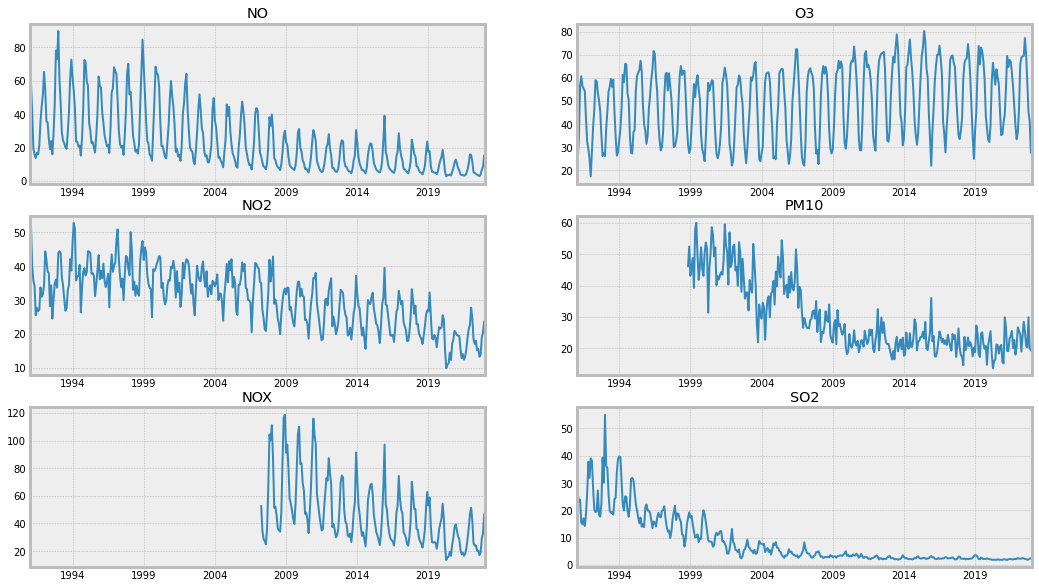

In [2]:
# 5) calculate averages by the year_month
feats1 = ['year_month','CONTAMINANT']
df1 = df.groupby(feats1)[feats_vals].mean().mean(axis = 1).unstack()
print(df1.shape)

_, ax = plt.subplots(3,2, figsize = (16,10))
for i,feat in enumerate(segm_top[:3]):
    _ = df1[feat].plot(title = feat, ax = ax[i][0], xlabel = '')
for i,feat in enumerate(segm_top[3:]):
    _ = df1[feat].plot(title = feat, ax = ax[i][1], xlabel = '')

### 2. Prophet model evaluation

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


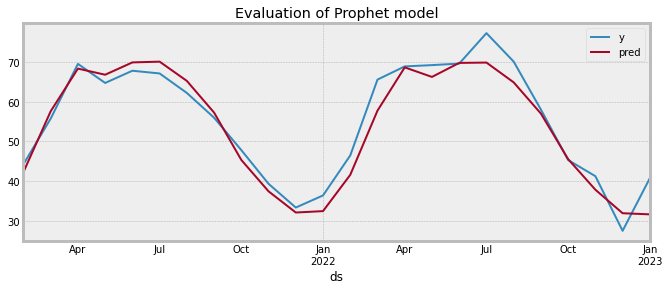

In [8]:
from prophet import Prophet

# 1) create datasets
feat = 'O3'
t1 = 24
x = df1[feat].reset_index()
x.columns = ['ds','y']
xt = x[-t1:]
x = x[:-t1]

# 2) build model
m = Prophet()
m.fit(x)

# 3) predict
df_out = m.make_future_dataframe(periods=t1, freq='m')
df_out = m.predict(df_out)
xt['pred'] = df_out[-t1:].yhat.values

# 4) plotting
_ = xt.set_index('ds').plot(figsize = (10,4), title = 'Evaluation of Prophet model')

In [4]:
# 5) evaluation
def ts_metrics(y_true, y_pred):
    return {
        'mae': metrics.mean_absolute_error(y_true, y_pred),
        'mse': metrics.mean_squared_error(y_true, y_pred),
        'mape': np.mean(np.abs((y_true - y_pred) / y_true)),
        'smape': np.mean(np.abs( 2*(y_true - y_pred) / (y_true+np.abs(y_pred)))),
        'nmse':  np.sum((y_true - y_pred)**2) / np.sum((y_true)**2),
    }
pd.Series(ts_metrics(xt.y, xt.pred))

{'mae': 3.030144338598429,
 'mse': 14.715596518003013,
 'mape': 0.06032912725917581,
 'smape': 0.06234250319109572,
 'nmse': 0.004546506296378711}

### 3. Prophet model predictions

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


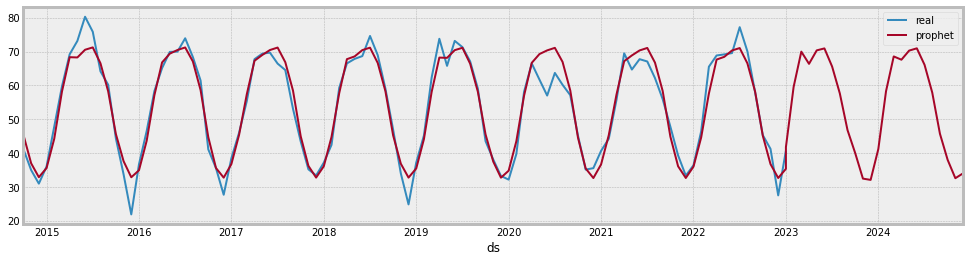

In [5]:
from prophet import Prophet

# 1) prepare dataframe
feat = 'O3'
x = df1[feat].reset_index()#[-12*10:]
x.columns = ['ds','y']

# 2) build model
m = Prophet()
m.fit(x)

# 3) predict
t1 = 24
df_out = m.make_future_dataframe(periods=t1, freq='m')
df_out = m.predict(df_out)

# 4) plotting
_ = x.set_index('ds')[-100:].plot(figsize = (15,4))
_ = df_out.set_index('ds')['yhat'][-124:].plot()
_ = _.legend(['real','prophet'])

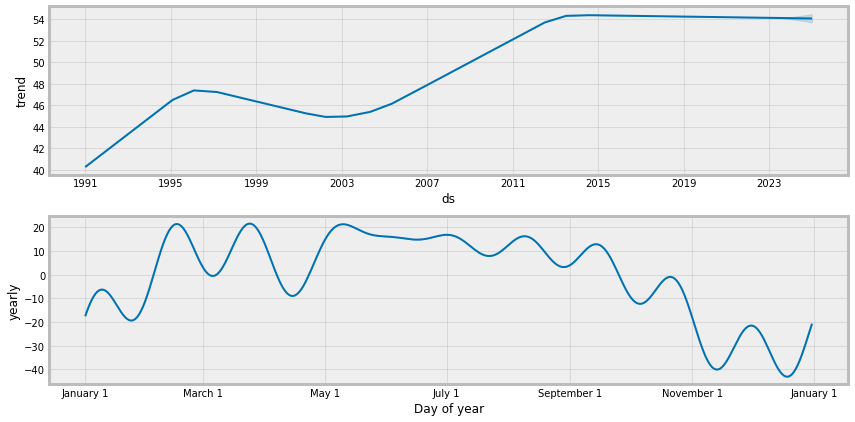

In [6]:
# explain model
m.plot_components(df_out, figsize = (12,6))
plt.show()